### This file contains Constraint-Kmeans alg. and relaed test results.
### Contents
*  I. n/a
* II. Helper functions
* III. Main function
* IV. Test & plots

In [194]:
import pandas as pd
import numpy as np
import os 
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import time
from pulp import *
import random as rd
import math
import random as rd
import sklearn.metrics as metrics

## II. Helper functions 

In [146]:
# find cenriod for empty clusters: 
def furthest_centroids(j,k,lable,features):
    centroids = get_centroids(features, lable, j)
    for index in range(j,k):
        temp = -1
        furthest = 0
        for i in range(len(features)):
            if lable[i] is None:
                dis = sum([euclidean_d(features[i],x) for x in centroids])
                if dis>temp:
                    temp = dis
                    furthest = i
        lable[furthest] = index
        centroids.append(features[index])
        #print(furthest)
    return centroids,lable

# return the lable of a cluster that is most similar to the unassigned group
def fit_lable(group,features,lable,ub,k):
    temp = 1000000
    lable_of_closest = 0
    for i in range(k):
        seeds = [x for x in range(len(lable)) if lable[x] == i]
        if len(seeds) + len(group)>ub: continue
        dis = group_d(seeds, group,features)
        if  dis < temp:
            temp = dis
            lable_of_closest = i
    return lable_of_closest

# return group distance
def group_d(g1,g2,features):
    d = 0
    for i in g1:
        for j in g2:
            d += euclidean_d(features[i],features[j])
    return d

# return object distance
def euclidean_d(a,b):
    return math.sqrt(sum([(x-y)*(x-y) for (x,y) in zip(a,b)]))

# get centriod
def get_centroids(features, lable, k):
    centroids = []
    for i in range(k):
        seeds = [x for x in range(len(lable)) if lable[x] == i]
        centroids.append(np.mean(np.array([features[x] for x in seeds]), axis=0))
    return centroids

# end condition 
def shouldStop(oldCentroids, centroids, iterations, alpha, MAX_ITERATIONS):
    if oldCentroids is None: return False
    if iterations > MAX_ITERATIONS: return True
    if sum([euclidean_d(x,y)>alpha for (x,y) in zip(oldCentroids,centroids)]) == 0: return True
    return False

# update lable
def get_lable(features, lable, centroids, free, ub, k):
    for i in free:
        if lable[i] is not None and sum([1 for x in lable if lable[i]==x])==1: continue
        temp = 1000000000
        lable_of_closest = lable[i]
        for j in range(k):
            if len([x for x in lable if x == j])<ub:
                dis = euclidean_d(centroids[j],features[i])
                if dis<temp:
                    temp = dis
                    lable_of_closest = j
        lable[i] = lable_of_closest
        #print(lable)
    return lable

## III. Main function 

In [280]:
def cons_km(features, ml, k, ub = 6, MAX_ITERATIONS = 100, alpha = 0.5, ground_truth =[]):
    
    """Clustering with must-link constraints and upper bound for cluster size.

    Args:
        features: An array with shape (n_objects,n_features)
        mustlink: A list containing the pre-defined group, ex.[[a,b],[c,d,e]] 
        k: Number of clusters
        ub: Upper bound for the cardinality of clusters. 
        iterations: max number of iterations
        alpha
        
    Returns:
        k clusters: lable, centriod, error at every iteration
        
    Raises:
        IOError: An error occurred when the given upper bound is not attainable.
    """
    
    ml.sort(key = len)
    ml = ml[::-1]
    lable = [None]*len(features)
    fix = []
    for group in ml:
        fix = fix + group
    free = [x for x in range(len(features)) if x not in fix]

    #initialize seeds
    if k > len(ml): 
        for i in range(len(ml)):
            for member in ml[i]:
                lable[member] = i
        centroids, lable = furthest_centroids(len(ml),k,lable,features)
    else:
        for i in range(k):
            for member in ml[i]:
                lable[member] = i
        for i in range(k,len(ml)):
            temp = fit_lable(ml[i],features,lable,ub,k)
            for member in ml[i]:
                lable[member] = temp
        centroids = get_centroids(features, lable, k)

    #k means:
    iterations = 0
    oldCentroids = None
    errors = []
    while not shouldStop(oldCentroids, centroids, iterations, alpha,MAX_ITERATIONS):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        #print(iterations)
        lable = get_lable(features, lable, centroids, free, ub, k)
        centroids = get_centroids(features, lable, k)
        if len(ground_truth)>0:
            errors.append(clusters_error(lable,ground_truth,features,centroids))
        else:
            errors.append(kmeans_error(centroids,lable,features))
            
    print('# of iterations:',iterations)
    return centroids,lable,errors

## IV. Test on Randam data

3
d [6, 7]
> [19, 18]
< [12, 13]
+ [1, 4, 5]


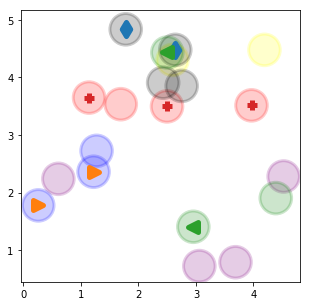

In [7]:
# random generate 20 points
f = [[rd.uniform(0,5),rd.uniform(0,5)] for x in range(20)]
mlml = [[1,4,5],[6,7],[19,18],[12,13]]

#constraints-kmean
cen,lab = cons_km(features=f,ml=mlml,k=6,alpha=0.5,MAX_ITERATIONS=1000,ub=4)

# visualize it
plt.figure(figsize=(5,5),)
colors = ['red', 'green','blue','black','yellow','purple']
plt.scatter([x[0] for x in f], [x[1] for x in f], s=1000, c=[colors[x] for x in lab],lw=3,alpha =0.2)

markers = ['x','+','<','>','d']
for group in mlml:
    temp = markers.pop()
    print(temp,group)
    plt.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=100,lw=5,marker=temp)
plt.show()

1001
1001
1001
1001
1001
1001
1001
32


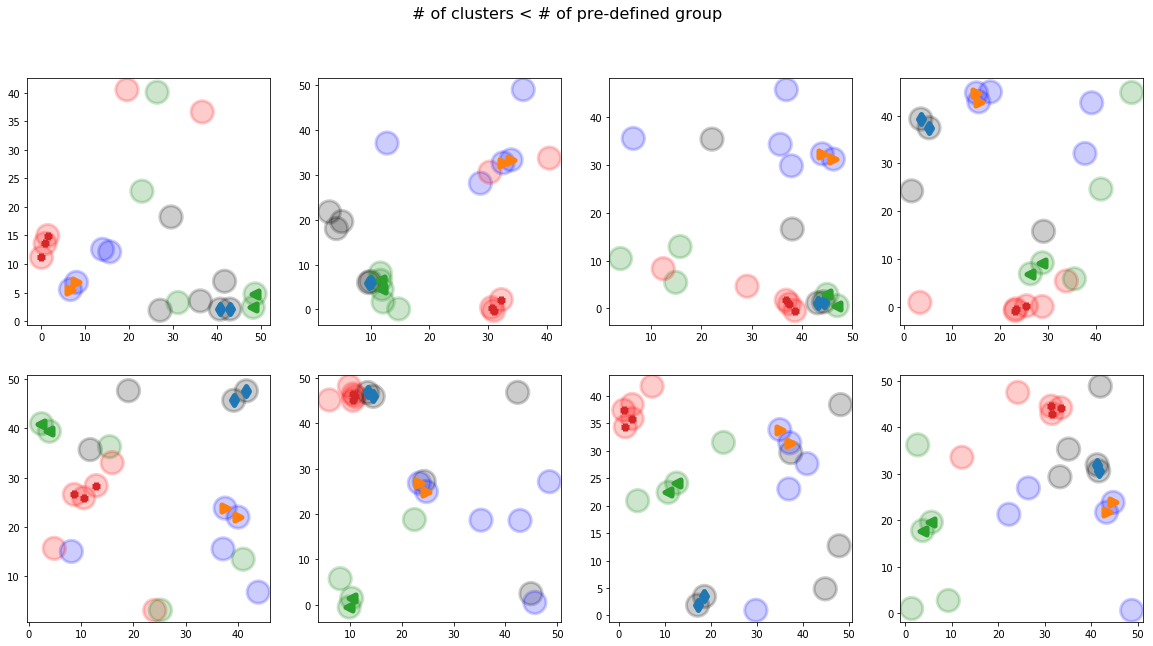

In [8]:
'''
Test on 20 data points
1.forced similarity within pre-fixed group 
2.# of clusters < # of pre-defined group
'''

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
fig.suptitle('# of clusters < # of pre-defined group', fontsize=16)

for row in ax:
    for col in row:
        #random generate 20 points
        f = [[rd.uniform(0,50),rd.uniform(0,50)] for x in range(20)]
        mlml = [[1,4,5],[6,7],[19,18],[12,13]]
        
        # make group similar:
        for group in mlml:
            for i in range(1,len(group)):
                f[group[i]][0] = f[group[0]][0] + rd.uniform(-2.5,2.5)
                f[group[i]][1] = f[group[0]][1] + rd.uniform(-2.5,2.5)
                
        #constraints-kmean
        cen,lab = cons_km(features=f,ml=mlml,k=4,alpha=0.5,MAX_ITERATIONS=1000)

        # visualize it
        
        colors = ['red', 'green','blue','black']
        col.scatter([x[0] for x in f], [x[1] for x in f], s=500, c=[colors[x] for x in lab],lw=3,alpha =0.2)

        markers = ['x','+','<','>','d']
        for group in mlml:
            temp = markers.pop()
            col.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=50,lw=5,marker=temp)

plt.show()

1001
1001
1001
1001
1001
1001
1001
1001


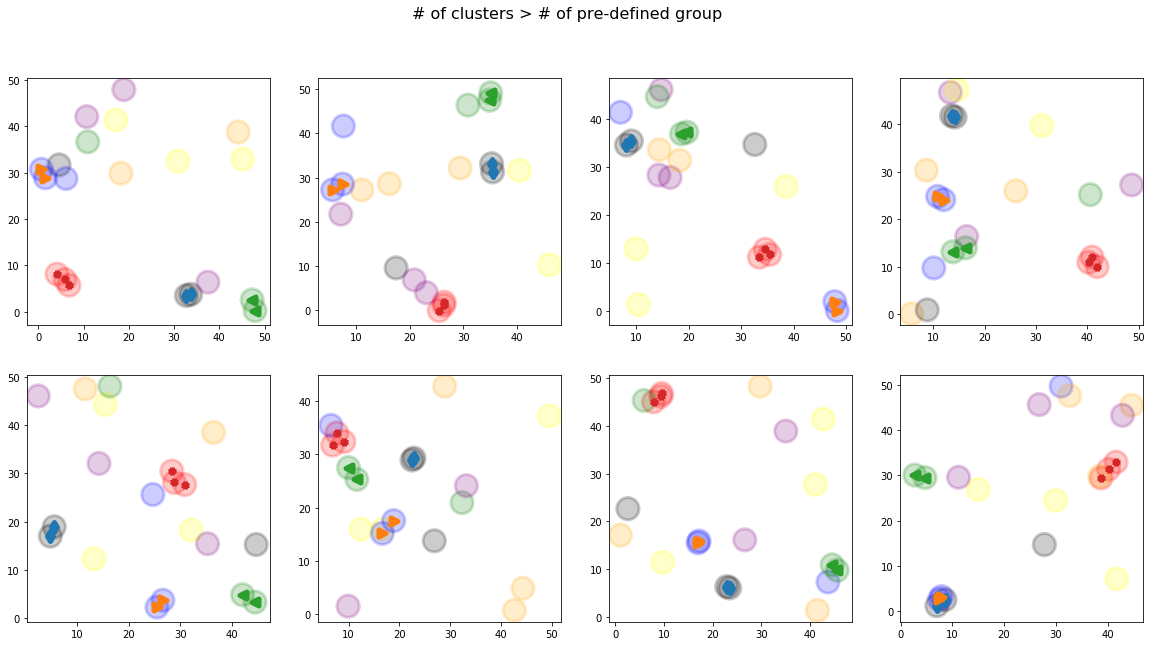

In [405]:
'''
Test on 20 data points with:
1.forced similarity within pre-fixed group 
2.# of clusters > # of pre-defined group
'''

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
fig.suptitle('# of clusters > # of pre-defined group', fontsize=16)

for row in ax:
    for col in row:
        #random generate 20 points
        f = [[rd.uniform(0,50),rd.uniform(0,50)] for x in range(20)]
        mlml = [[1,4,5],[6,7],[19,18],[12,13]]
        
        # make group similar:
        for group in mlml:
            for i in range(1,len(group)):
                f[group[i]][0] = f[group[0]][0] + rd.uniform(-2.5,2.5)
                f[group[i]][1] = f[group[0]][1] + rd.uniform(-2.5,2.5)
                
        #constraints-kmean
        cen,lab = cons_km(features=f,ml=mlml,k=7,alpha=0.5,MAX_ITERATIONS=1000,ub=3)

        # visualize it
        
        colors = ['red', 'green','blue','black','purple','yellow','orange']
        col.scatter([x[0] for x in f], [x[1] for x in f], s=500, c=[colors[x] for x in lab],lw=3,alpha =0.2)

        markers = ['x','+','<','>','d']
        for group in mlml:
            temp = markers.pop()
            col.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=50,lw=5,marker=temp)

plt.show()

## V. Test on blob data

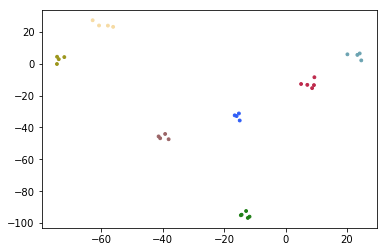

In [281]:
# generate data with ground true 

import sklearn.datasets as sk_data

X, y = sk_data.make_blobs(n_samples=30, centers=7, n_features=2,
                          center_box=(-100.0, 100.0),random_state=2,cluster_std =2)
plt.scatter(X[:, 0], X[:, 1], s=8,c=[colors[x] for x in y])
plt.show()

In [297]:
# generate must-links
def must_links_generators(X,k,lb,ub):
    """generates k pre-defined groups among the objects represented by X

    Args:
        X: Objects matrix
        k: Number of pre-defined groups
        lb,ub: Size of group subjects to (lb,ub)
    Returns:
        A 2d list that represents k pre-defined group.
    Raise:
        IOError if cannot generate k satisfying groups
    """
    must_links = [] 
    pool = [x for x in range(len(X))]
    for i in range(k):
        if len(pool) == 0: raise IOError("k or size too large")
        rd.shuffle(pool)
        size = rd.randint(2,4)
        must_links.append(pool[-size:])
        pool = pool[:-size]
    return must_links

def clusters_error(lable,y,x,centroid):
    # rand index
    ri = 1-metrics.adjusted_rand_score(lable,y)
    # jacard distance
    jd = sum([a!=b for (a,b) in zip(lable,y)])/len(y)
    # kmeans errors
    ke = kmeans_error(centroid,lable,x)
    return [ri,jd,ke]

def kmeans_error(centroid,lable,x):
    error = 0
    for (a,b) in zip(lable,x):
        error += euclidean_d(centroid[a],b)
    return error

must_links: [[6, 29, 19, 15], [10, 24, 18], [21, 1, 28], [13, 25, 23, 5], [22, 11, 16, 14]]
# of iterations: 1001


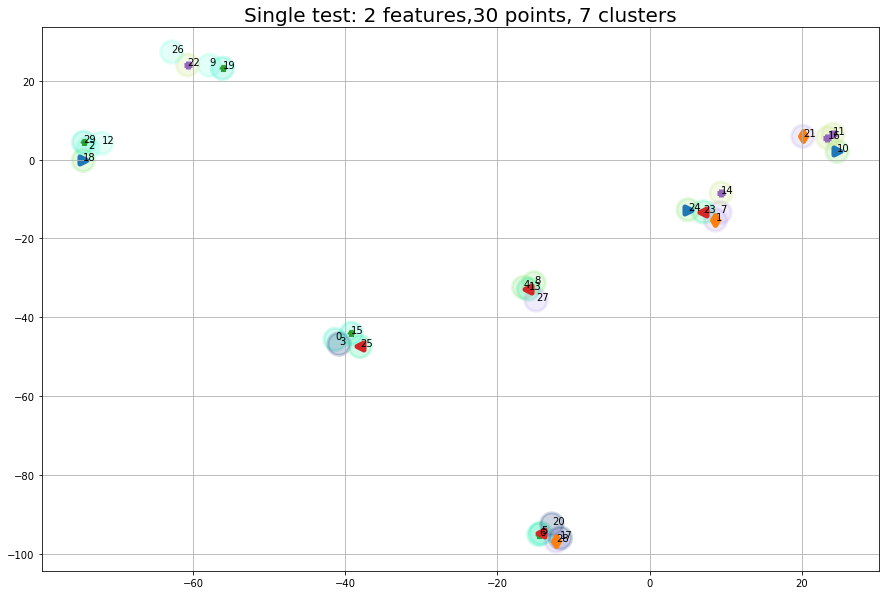

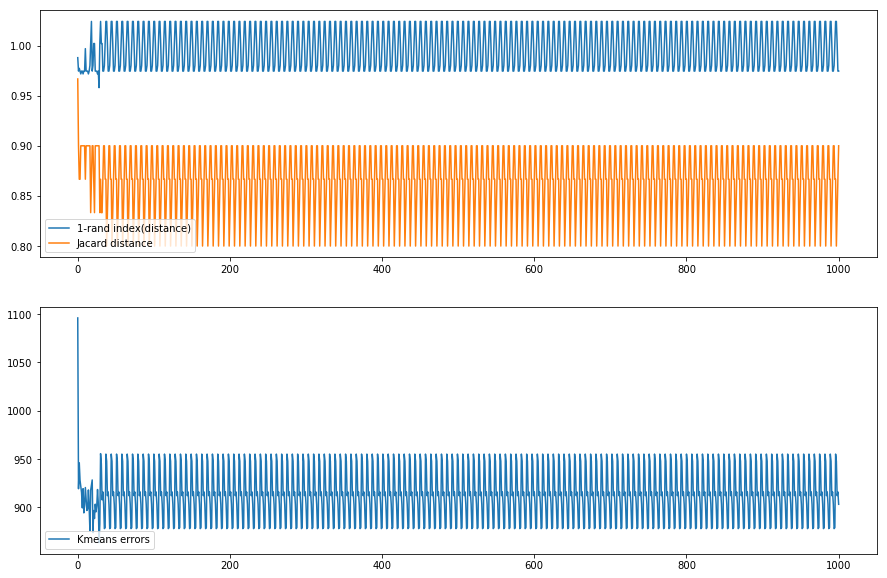

In [300]:
"""
Single test: 2 feature
"""
#constraints-kmean
mlml = must_links_generators(X,5,2,3)
f = X.tolist()
print('must_links:',mlml)
cen,lab,errors = cons_km(features=f,ml=mlml,k=7,alpha=0.01,MAX_ITERATIONS=1000,ub=5,ground_truth=y)

# visualize plot
fig, ax = plt.subplots(figsize=(15,10))
r = lambda: rd.randint(0,255)
colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

plt.scatter([x[0] for x in f], [x[1] for x in f], s=500, c=[colors[x] for x in lab],lw=3,alpha =0.2)

markers = ['2','3','4','8','x','+','<','1','d','>']
for group in mlml:
    temp = markers.pop()
    plt.scatter([f[x][0] for x in group], [f[x][1] for x in group], s=50,lw=5,marker=temp)

for i, txt in enumerate(range(len(f))):
    ax.annotate(txt, (f[i][0],f[i][1]))
plt.title('Single test: 2 features,30 points, 7 clusters',fontsize =20)
plt.grid()
plt.show()

# visualize error
plt.figure(figsize=(15,10))
plt.subplot(211)
l1, =plt.plot(range(len(errors)),[x[0] for x in errors],label ='1-rand index(distance)')
l2, = plt.plot(range(len(errors)),[x[1] for x in errors],label ='Jacard distance')
plt.legend(handles=[l1,l2], loc=3)

plt.subplot(212)
l3, = plt.plot(range(len(errors)),[x[2] for x in errors],label ='Kmeans errors')
plt.legend(handles=[l3], loc=3)
plt.show()



In [301]:
"""
How error change as #constraints increases?
"""
for_plot  =[]
mlml = must_links_generators(X,9,2,3)
for i in range(9):
    f = X.tolist()
    print('must_links:',mlml[:i])
    cen,lab,errors = cons_km(features=f,ml=mlml[:i],k=7,alpha=0.01,MAX_ITERATIONS=1000,ub=5,ground_truth=y)
    min_ri = min([x[0] for x in errors])
    min_jd = min([x[1] for x in errors])
    min_ke = min([x[2] for x in errors])
    for_plot.append((min_ri,min_jd,min_ke,errors[-1][0],errors[-1][1],errors[-1][2]))

must_links: []
# of iterations: 1001
must_links: [[8, 20, 15, 9]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11], [10, 4, 25, 3]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11], [10, 4, 25, 3], [1, 26]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11], [10, 4, 25, 3], [1, 26], [19, 7, 18]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11], [10, 4, 25, 3], [1, 26], [19, 7, 18], [6, 28]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11], [10, 4, 25, 3], [1, 26], [19, 7, 18], [6, 28], [14, 12, 29, 13]]
# of iterations: 1001
must_links: [[8, 20, 15, 9], [17, 23, 11], [10, 4, 25, 3], [1, 26], [19, 7, 18], [6, 28], [14, 12, 29, 13], [5, 22, 0, 24]]
# of iterations: 1001


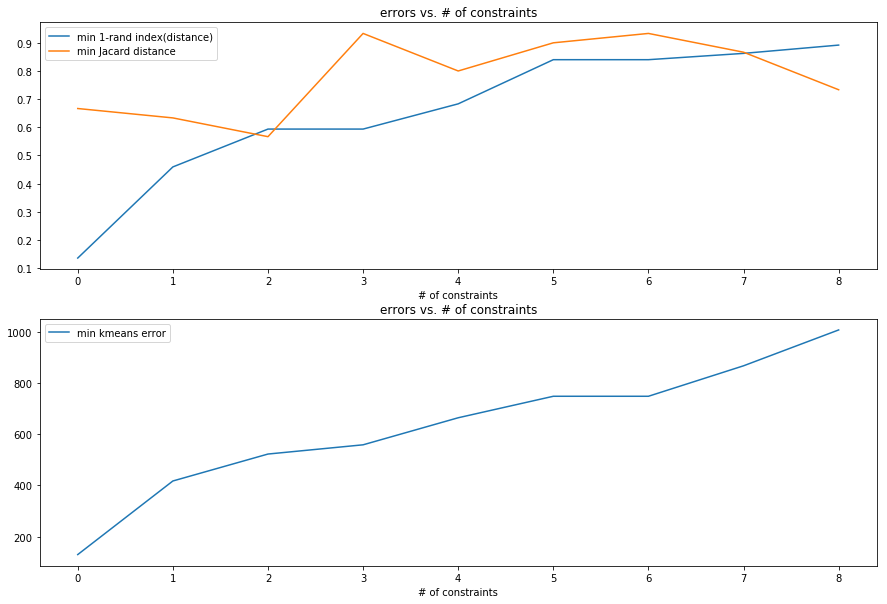

In [313]:
plt.figure(figsize=(15,10))
plt.subplot(211)
l1, =plt.plot(range(len(for_plot)),[x[0] for x in for_plot],label ='min 1-rand index(distance)')
l2, = plt.plot(range(len(for_plot)),[x[1] for x in for_plot],label ='min Jacard distance')
# l3, = plt.plot(range(len(for_plot)),[x[3] for x in for_plot],label ='1-rand index(distance)')
# l4, = plt.plot(range(len(for_plot)),[x[4] for x in for_plot],label ='Jacard distance')
plt.xlabel('# of constraints')
plt.title('errors vs. # of constraints')
plt.legend(handles=[l1,l2], loc=2)


plt.subplot(212)
plt.xlabel('# of constraints')
plt.title('errors vs. # of constraints')
l5, =plt.plot(range(len(for_plot)),[x[2] for x in for_plot],label ='min kmeans error')
# l6, =plt.plot(range(len(for_plot)),[x[5] for x in for_plot],label ='kmeans error')

plt.legend(handles=[l5], loc=2)
plt.show()

In [314]:
'''
Tests with more features
'''
X, y = sk_data.make_blobs(n_samples=100, centers=30, n_features=5,
                          center_box=(-100.0, 100.0),random_state=2,cluster_std =2)

In [315]:
for_plot  =[]
mlml = must_links_generators(X,30,2,3)
for i in range(30):
    f = X.tolist()
    print('must_links:',mlml[:i])
    cen,lab,errors = cons_km(features=f,ml=mlml[:i],k=30,alpha=0.01,MAX_ITERATIONS=500,ub=5,ground_truth=y)
    min_ri = min([x[0] for x in errors])
    min_jd = min([x[1] for x in errors])
    min_ke = min([x[2] for x in errors])
    for_plot.append((min_ri,min_jd,min_ke,errors[-1][0],errors[-1][1],errors[-1][2]))

must_links: []
# of iterations: 501
must_links: [[27, 78, 19]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36], [54, 56, 69, 57]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36], [54, 56, 69, 57], [5, 86, 75, 80]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36], [54, 56, 69, 57], [5, 86, 75, 80], [39, 74, 18, 79]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36], [54, 56, 69, 57], [5, 86, 75, 80], [39, 74, 18, 79], [24, 91, 72, 60]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36], [54, 56, 69, 57], [5, 86, 75, 80], [39, 74, 18, 79], [24, 91, 72, 60], [47, 48, 73, 33]]
# of iterations: 501
must_links: [[27, 78, 19], [76, 46, 62, 26], [10, 15, 36], [54, 56, 69, 57], [5, 86, 75, 80], [39, 74, 1

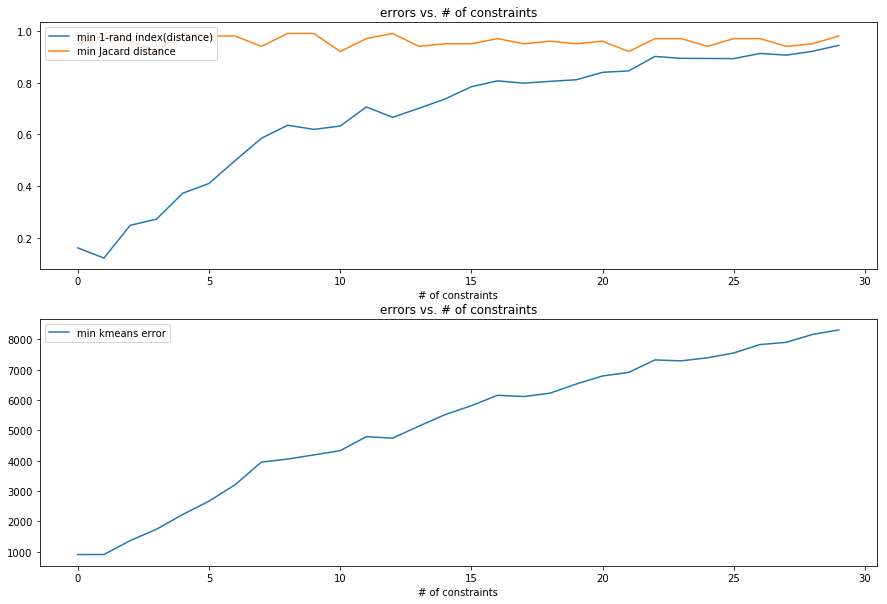

In [316]:
plt.figure(figsize=(15,10))
plt.subplot(211)
l1, =plt.plot(range(len(for_plot)),[x[0] for x in for_plot],label ='min 1-rand index(distance)')
l2, = plt.plot(range(len(for_plot)),[x[1] for x in for_plot],label ='min Jacard distance')
# l3, = plt.plot(range(len(for_plot)),[x[3] for x in for_plot],label ='1-rand index(distance)')
# l4, = plt.plot(range(len(for_plot)),[x[4] for x in for_plot],label ='Jacard distance')
plt.xlabel('# of constraints')
plt.title('errors vs. # of constraints')
plt.legend(handles=[l1,l2], loc=2)


plt.subplot(212)
plt.xlabel('# of constraints')
plt.title('errors vs. # of constraints')
l5, =plt.plot(range(len(for_plot)),[x[2] for x in for_plot],label ='min kmeans error')
# l6, =plt.plot(range(len(for_plot)),[x[5] for x in for_plot],label ='kmeans error')

plt.legend(handles=[l5], loc=2)
plt.show()

In [317]:
'''
test on the change of #clusters
'''
for_plot  =[]
mlml = must_links_generators(X,30,2,3)
for i in range(22,35):
    f = X.tolist()
#     print('must_links:',mlml[:i])
    cen,lab,errors = cons_km(features=f,ml=mlml[:10],k=i,alpha=0.01,MAX_ITERATIONS=500,ub=5,ground_truth=y)
    min_ri = min([x[0] for x in errors])
    min_jd = min([x[1] for x in errors])
    min_ke = min([x[2] for x in errors])
    for_plot.append((min_ri,min_jd,min_ke,errors[-1][0],errors[-1][1],errors[-1][2]))

# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501
# of iterations: 501


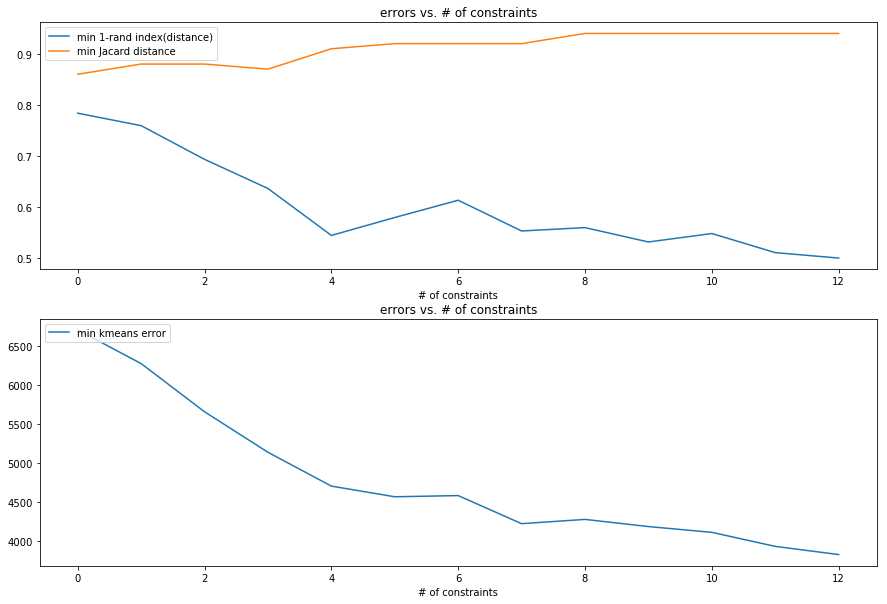

In [318]:
plt.figure(figsize=(15,10))
plt.subplot(211)
l1, =plt.plot(range(len(for_plot)),[x[0] for x in for_plot],label ='min 1-rand index(distance)')
l2, = plt.plot(range(len(for_plot)),[x[1] for x in for_plot],label ='min Jacard distance')
# l3, = plt.plot(range(len(for_plot)),[x[3] for x in for_plot],label ='1-rand index(distance)')
# l4, = plt.plot(range(len(for_plot)),[x[4] for x in for_plot],label ='Jacard distance')
plt.xlabel('# of constraints')
plt.title('errors vs. # of constraints')
plt.legend(handles=[l1,l2], loc=2)


plt.subplot(212)
plt.xlabel('# of constraints')
plt.title('errors vs. # of constraints')
l5, =plt.plot(range(len(for_plot)),[x[2] for x in for_plot],label ='min kmeans error')
# l6, =plt.plot(range(len(for_plot)),[x[5] for x in for_plot],label ='kmeans error')

plt.legend(handles=[l5], loc=2)
plt.show()